# imports and functions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import re
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors


In [ ]:
def nan_info(dataframe, show_count=False):
    # Create a boolean mask for NaN values
    nan_mask = dataframe.isna()
    # Get the indices where NaN values are present
    nan_indices = dataframe.index[nan_mask.any(axis=1)].tolist()
    # Get the columns with NaN values
    nan_columns = dataframe.columns[nan_mask.any()].tolist()
    # Count NaN values for each column
    nan_count_per_column = nan_mask.sum()
    # print("Timesteps with NaN values:", nan_indices)
    print("Columns with NaN values:", nan_columns)
    if show_count:
        print("Number of NaN values in each column:")
        print(nan_count_per_column)
    return
def missing_dates(df,freq):
    # Generate a complete date range from the minimum to maximum date in the DataFrame
    complete_date_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq=freq)

    # Find the missing dates by subtracting the existing dates from the complete date range
    missing_dates = complete_date_range.difference(df.index)

    # Print or display the missing dates
    print("Missing dates:", missing_dates)

In [ ]:
# Define a function to rename the temperature column and drop other columns
def rename_and_filter_temp_columns(df):
    # Use a regular expression to find the temperature column
    temp_col = None
    for col in df.columns:
        if re.search(r'Temperature\s*\(°C\)', col):
            temp_col = col
            break

    if temp_col:
        # Rename the column to 'Temp'
        df = df.rename(columns={temp_col: 'Temp'})
        # Keep only the 'Temp' column
        # df = df[['Temp','Station']]
        df = df[['Temp']]

    return df

# Extreme outlier removal functions

In [ ]:
def remove_extreme_outliers(df, column_name, threshold=2.5, diff_threshold=7):
    # Calculate z-scores
    z_scores = (df[column_name] - df[column_name].mean()) / df[column_name].std()

    # Identify z-score outliers
    z_outliers = np.abs(z_scores) > threshold

    # Calculate the difference between consecutive values
    diff = df[column_name].diff().abs()

    # Identify difference outliers
    diff_outliers = diff > diff_threshold

    # Replace outliers with NaN
    df.loc[z_outliers, column_name] = np.nan
    df.loc[diff_outliers, column_name] = np.nan

    return df


In [ ]:
def smooth_time_series(df, column_name, window_size=18):
    # Calculate rolling mean (moving average)
    rolling_mean = df[column_name].rolling(window=window_size, center=True).mean()

    # Replace original values with smoothed values
    df[column_name] = rolling_mean

    return df

In [ ]:
import matplotlib.pyplot as plt

def detect_and_plot_anomalies(df, column_name, threshold=8, figsize=(20, 6)):
    # Calculate differences between consecutive values
    df['diff'] = df[column_name].diff()

    # Flag anomalies where the absolute difference exceeds the threshold
    df['anomaly'] = df['diff'].abs() > threshold

    # Plot the time series data with flagged anomalies
    plt.figure(figsize=figsize)
    plt.plot(df.index, df[column_name], label='Time Series Data', color='blue')

    # Highlight detected anomalies
    anomaly_indices = df[df['anomaly']].index
    plt.scatter(anomaly_indices, df.loc[anomaly_indices, column_name], color='red', label='Anomaly')

    plt.title('Time Series Data with Flagged Anomalies')
    plt.xlabel('Date')
    plt.ylabel('Temperature')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Print indices of flagged anomalies
    # print("Indices of Flagged Anomalies:", anomaly_indices)
    df.drop(['diff', 'anomaly'], axis=1, inplace=True)
    return
# Example usage:
# detect_and_plot_anomalies(fdf_za, 'Temp')

In [ ]:

def fix_zazari(data_frames):
    # Specify the range you want to set to NaN
    start_date = '2019-02-12'
    end_date = '2019-04-19'

    # Ensure 'zazari' column exists in data_frames
    if 'zazari' not in data_frames or 'Temp' not in data_frames['zazari']:
        raise KeyError("zazari['Temp'] column not found in data_frames")

    # Convert index to datetime if not already in datetime format
    data_frames['zazari'].index = pd.to_datetime(data_frames['zazari'].index)

    # Create a boolean mask for the specified range
    mask = (data_frames['zazari'].index >= start_date) & (data_frames['zazari'].index <= end_date)

    # Mark values in the specified range as NaN
    data_frames['zazari'].loc[mask, 'Temp'] = pd.NA
    print('okay')
    return


In [ ]:
def find_anomalies(df, feature_column='Temp', k=5, threshold_multiplier=2.0):
    temp_df = df.copy()  # Create a copy of the dataframe to avoid modifying the original
    temp_df.dropna(inplace=True)  # Drop rows with missing values

    # Select the feature(s) to be used
    features = temp_df[[feature_column]]

    # Standardize the features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Fit the k-Nearest Neighbors model
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(features_scaled)

    # Find k-neighbors and calculate mean distances
    distances, indices = knn.kneighbors(features_scaled)
    mean_distances = distances.mean(axis=1)

    # Calculate the anomaly threshold
    threshold = mean_distances.mean() + threshold_multiplier * mean_distances.std()

    # Identify anomalies
    anomalies = mean_distances > threshold
    anomaly_indices = temp_df.index[anomalies]
    anomalies_df = df.loc[anomaly_indices]
    print(f'Number of anomalies found: {sum(anomalies)}')
    # Plot temperature data with anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(df.index, df[feature_column], label='Temperature')
    plt.xlabel('Index')
    plt.ylabel('Temperature')
    plt.title('Temperature with Anomalies')
    plt.scatter(anomaly_indices, anomalies_df[feature_column], color='red', label='Anomalies')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    return anomalies_df

# Example usage:
# anomalies_df = find_anomalies(data_frames['zazari'], feature_column='Temp', k=5, threshold_multiplier=2.0)



# Load

In [ ]:
# Define the path to the directory containing the CSV files
path = '/content/weather_data'

# Get a list of all CSV files in the directory
csv_files = glob.glob(os.path.join(path, "*.csv"))

# Initialize an empty list to store DataFrames
data_frames = {}

# Loop through the list of CSV files and read each into a DataFrame
for file in csv_files:
    # Read the CSV file
    df = pd.read_csv(file,encoding='iso-8859-1',delimiter=';',dtype=object)
    # Combine 'date' and 'time' columns into a new 'datetime' column
    df['Datetime'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%m/%d/%y %I:%M:%S %p')
    # Drop the original 'date' and 'time' columns if needed
    df.drop(['Date', 'Time'], axis=1, inplace=True)
    df.set_index('Datetime', inplace=True)
    #Convert columns to numeric
    numeric_columns = df.columns.tolist()
    df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

    # Aggregate duplicate timestamps by taking the mean
    df = df.groupby(level=0).mean()
    # Resample to hourly intervals
    df = df.resample('10min').asfreq()

    station_name = os.path.basename(file).split('.')[0]  # Assuming the file name is the station name
    print(station_name)
    # df['Station'] = station_name
    # Append the DataFrame to the list
    # data_frames.append(df)
    data_frames[station_name]=df


# Apply the function to each DataFrame in the dictionary
for station, df in data_frames.items():
    data_frames[station] = rename_and_filter_temp_columns(df)

# # Concatenate all DataFrames in the list into a single DataFrame
# combined_df = pd.concat(data_frames)


kalliniki
polipotamos
vevi
nimfaio
aminteo
maniaki
antigono
zazari


In [ ]:
fix_zazari(data_frames)

okay


In [ ]:
# REMOVE OUTLIERS
for station, df in data_frames.items():
    print(station)
    data_frames[station] = remove_extreme_outliers(data_frames[station], 'Temp')

kalliniki
polipotamos
vevi
nimfaio
aminteo
maniaki
antigono
zazari


In [ ]:
smooth_time_series(data_frames['nimfaio'],'Temp')

,Temp
Datetime,
2017-06-21 14:00:00,NaN
2017-06-21 14:10:00,NaN
2017-06-21 14:20:00,NaN
2017-06-21 14:30:00,NaN
2017-06-21 14:40:00,NaN
...,...
2022-10-28 16:50:00,NaN
2022-10-28 17:00:00,NaN
2022-10-28 17:10:00,NaN


In [ ]:
smooth_time_series(data_frames['polipotamos'],'Temp')

,Temp
Datetime,
2017-06-22 12:40:00,NaN
2017-06-22 12:50:00,NaN
2017-06-22 13:00:00,NaN
2017-06-22 13:10:00,NaN
2017-06-22 13:20:00,NaN
...,...
2022-01-05 12:20:00,NaN
2022-01-05 12:30:00,NaN
2022-01-05 12:40:00,NaN


In [ ]:
# # Display the modified dataframes for verification
# for station, df in data_frames.items():
#     print(station)
#     # Apply the function
#     detect_and_plot_anomalies(df, 'Temp')

In [ ]:
# Display the modified dataframes for verification
for station, df in data_frames.items():
    print(station)
    # print(df.columns)
    nan_info(df,show_count=True)

kalliniki
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    18217
dtype: int64
polipotamos
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    20603
dtype: int64
vevi
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    101710
dtype: int64
nimfaio
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    159754
dtype: int64
aminteo
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    31982
dtype: int64
maniaki
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    68
dtype: int64
antigono
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    2158
dtype: int64
zazari
Columns with NaN values: ['Temp']
Number of NaN values in each column:
Temp    11081
dtype: int64


In [ ]:
for station, df in data_frames.items():
    print(station,len(df))
    # max=382905

kalliniki 289450
polipotamos 238755
vevi 349777
nimfaio 281542
aminteo 382905
maniaki 8569
antigono 367178
zazari 350750


# Merge data

In [ ]:
# Convert the dictionary values (DataFrames) into a list
dfs_list = list(data_frames.values())

In [ ]:
# Concatenate the DataFrames along the index (assuming datetime is the index)
combined_df = pd.concat(dfs_list, keys=data_frames.keys(),axis=1)

In [ ]:
combined_df.columns = combined_df.columns.map(lambda x: '_'.join(x) if isinstance(x, tuple) else x)


In [ ]:
combined_df=combined_df['2018':'2023']

In [ ]:
combined_df.head(n=100)

,kalliniki_Temp,polipotamos_Temp,vevi_Temp,nimfaio_Temp,aminteo_Temp,maniaki_Temp,antigono_Temp,zazari_Temp
Datetime,,,,,,,,
2018-01-01 00:00:00,-2.8,2.816667,4.0,NaN,-1.9,NaN,3.2,-0.1
2018-01-01 00:10:00,-2.4,2.833333,NaN,NaN,-3.0,NaN,1.3,0.3
2018-01-01 00:20:00,-2.3,2.850000,NaN,NaN,-2.9,NaN,1.7,0.2
2018-01-01 00:30:00,-2.3,2.872222,3.3,NaN,-2.7,NaN,2.5,0.0
2018-01-01 00:40:00,-2.4,2.905556,NaN,NaN,-2.3,NaN,3.7,0.1
...,...,...,...,...,...,...,...,...
2018-01-01 15:50:00,6.4,9.483333,NaN,NaN,10.4,NaN,11.0,12.3
2018-01-01 16:00:00,6.2,9.416667,8.5,NaN,9.4,NaN,10.4,11.4
2018-01-01 16:10:00,6.1,9.277778,NaN,NaN,9.3,NaN,9.2,11.0


In [ ]:
final_df = combined_df.interpolate(method='linear',limit_direction='both', axis=1)

In [ ]:
final_df = final_df.resample('H').asfreq()

In [ ]:
final_df = final_df.interpolate(method='linear', axis=0)

In [ ]:
final_df=final_df['2018':'2023']

In [ ]:
nan_info(final_df,show_count=True)

Columns with NaN values: []
Number of NaN values in each column:
kalliniki_Temp      0
polipotamos_Temp    0
vevi_Temp           0
nimfaio_Temp        0
aminteo_Temp        0
maniaki_Temp        0
antigono_Temp       0
zazari_Temp         0
dtype: int64


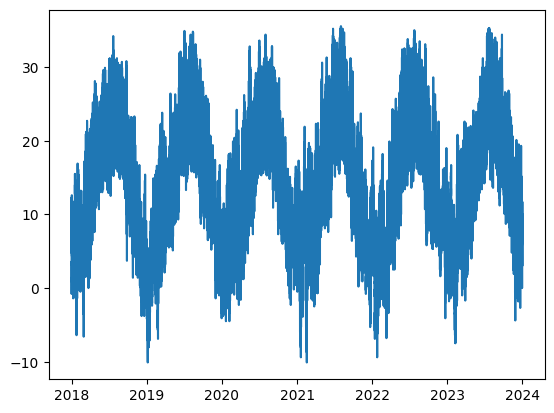

In [ ]:
plt.plot(final_df['antigono_Temp'])

In [ ]:
remove_extreme_outliers(final_df,'polipotamos_Temp')

,kalliniki_Temp,polipotamos_Temp,vevi_Temp,nimfaio_Temp,aminteo_Temp,maniaki_Temp,antigono_Temp,zazari_Temp
Datetime,,,,,,,,
2018-01-01 00:00:00,-2.8,2.816667,4.0,1.05,-1.9,0.65,3.2,-0.1
2018-01-01 01:00:00,-2.4,2.961111,3.3,0.15,-3.0,0.30,3.6,-0.1
2018-01-01 02:00:00,-2.4,3.011111,2.6,-0.20,-3.0,-0.20,2.6,-0.6
2018-01-01 03:00:00,-2.3,3.344444,2.6,-0.65,-3.9,-0.55,2.8,-1.1
2018-01-01 04:00:00,-2.9,3.722222,2.6,-1.15,-4.9,-1.00,2.9,-0.7
...,...,...,...,...,...,...,...,...
2023-12-31 19:00:00,9.2,9.200000,9.2,6.90,4.6,7.60,7.4,5.7
2023-12-31 20:00:00,8.5,8.500000,8.5,6.90,5.3,6.30,7.0,5.1
2023-12-31 21:00:00,8.7,8.700000,8.7,6.05,3.4,3.00,7.4,4.8


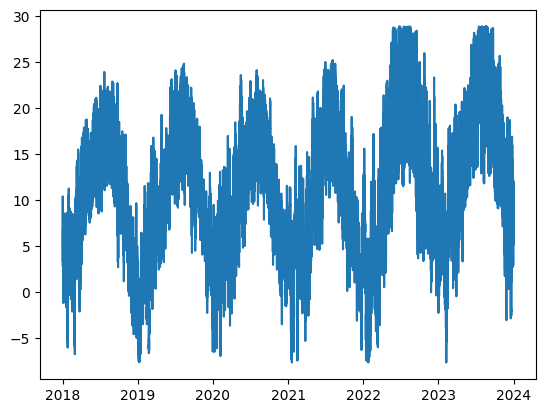

In [ ]:
plt.plot(final_df['polipotamos_Temp'])

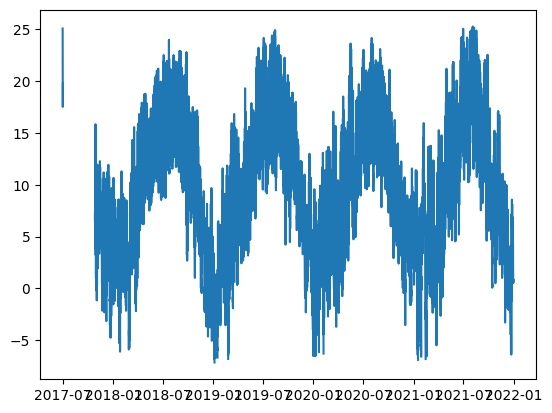

In [ ]:
plt.plot(data_frames['polipotamos']['Temp'])

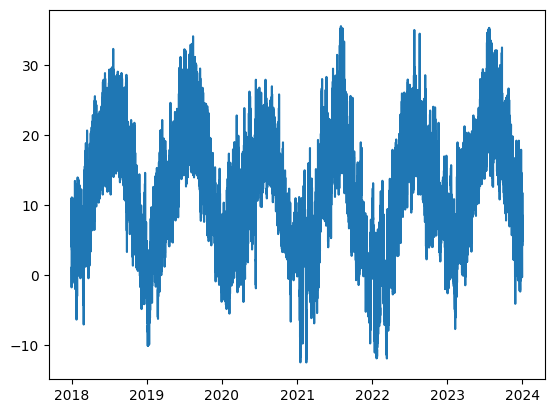

In [ ]:
plt.plot(final_df['nimfaio_Temp'])

In [ ]:
dfd = final_df.resample('D').asfreq()
dfm = final_df.resample('M').asfreq()
dfy = final_df.resample('Y').asfreq()

# SAVE TO EXCEL

In [ ]:
excel_file_path='ΘΕΡΜΟΚΡΑΣΙΕΣ 2020-2023.xlsx'
with pd.ExcelWriter(excel_file_path) as writer:
    final_df.to_excel(writer, sheet_name='ΩΡΑ')
    dfd.to_excel(writer, sheet_name='ΜΕΡΑ')
    dfm.to_excel(writer, sheet_name='ΜΗΝΑΣ')
    dfy.to_excel(writer, sheet_name='ΧΡΟΝΟΣ')

ZAZARI GONE BAD FROM '2019-02-12':'2019-04-19'